#  Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras import Model
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preprocesado


In [3]:
def load_and_rotate_image(file_path, image_size=224):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_size, image_size])
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    label = k
    image = tf.image.rot90(image, k=k)
    image = (image / 127.5) - 1.0
    return image, label



## Crear dataset

In [4]:
def create_rotnet_dataset(image_dir, image_size=224, batch_size=32):
    print(f"📁 Cargando imágenes desde: {image_dir}")

    image_paths = []
    for root, _, files in os.walk(image_dir):
        for fname in files:
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(root, fname))
    print(f"🔢 Total de imágenes encontradas: {len(image_paths)}")
   

    dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    # Mapear con la función de carga y rotación
    dataset = dataset.map(lambda path: load_and_rotate_image(path, image_size=image_size),
                          num_parallel_calls=tf.data.AUTOTUNE)

    #normalizar las imágenes
    def normalize_image(image, label=None):
        image = tf.cast(image, tf.float32) / 255.0  # Normalizar a [0, 1]
        return image, label
    dataset = dataset.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
    # Barajar, agrupar en lotes y prefetch
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)


    print(f"⏱️ Preprocesamiento completado.\n")

    return dataset


In [5]:
image_dir = "e:/TFM/DB/pocRotnet"
image_dir="e:/TFM/PlantsClassification/train"
# image_dir = os.path.join(execution_path,  "pocRotnet")
train = create_rotnet_dataset("e:/TFM/PlantsClassification/train")
test= create_rotnet_dataset("e:/TFM/PlantsClassification/test")
val= create_rotnet_dataset("e:/TFM/PlantsClassification/val")

📁 Cargando imágenes desde: e:/TFM/PlantsClassification/train
🔢 Total de imágenes encontradas: 20300
⏱️ Preprocesamiento completado.

📁 Cargando imágenes desde: e:/TFM/PlantsClassification/test
🔢 Total de imágenes encontradas: 5800
⏱️ Preprocesamiento completado.

📁 Cargando imágenes desde: e:/TFM/PlantsClassification/val
🔢 Total de imágenes encontradas: 2900
⏱️ Preprocesamiento completado.



##  Definir modelo

In [6]:
model = base_model = tf.keras.applications.ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(29, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                        

## Ejecutar entrenamiento

In [13]:
# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print("🚀 Comenzando el entrenamiento...\n")

for batch in train.take(1):
    x, y = batch
    print("🧪 x shape:", x.shape)
    print("🧪 y shape:", y.shape)
    print("🧪 y dtype:", y.dtype)
    print("🧪 y example:", y[0])
# history = model.fit(dataset, epochs=100, verbose=2)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5 , restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_modelV5.h5', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.2, min_lr=1e-6),
]

history = model.fit(
    train,
    validation_data=test,
    epochs=50,
    callbacks=callbacks,
    verbose=1

)



print(f"\n✅ Entrenamiento finalizado.")

save_path = "E:/TFM/rotnet_model3.keras"
model.save(save_path)
print(f"💾 Modelo guardado en: {save_path}")


🚀 Comenzando el entrenamiento...

🧪 x shape: (32, 224, 224, 3)
🧪 y shape: (32,)
🧪 y dtype: <dtype: 'int32'>
🧪 y example: tf.Tensor(1, shape=(), dtype=int32)
Epoch 1/50
635/635 [==============================] - 172s 261ms/step - loss: 1.3608 - accuracy: 0.3633 - val_loss: 1.6835 - val_accuracy: 0.2595 - lr: 1.0000e-04
Epoch 2/50
635/635 [==============================] - 167s 262ms/step - loss: 1.2229 - accuracy: 0.4647 - val_loss: 1.5750 - val_accuracy: 0.4045 - lr: 1.0000e-04
Epoch 3/50
635/635 [==============================] - 167s 262ms/step - loss: 1.1250 - accuracy: 0.5254 - val_loss: 1.5081 - val_accuracy: 0.4698 - lr: 1.0000e-04
Epoch 4/50
635/635 [==============================] - 169s 264ms/step - loss: 1.0055 - accuracy: 0.5862 - val_loss: 1.3546 - val_accuracy: 0.4714 - lr: 1.0000e-04
Epoch 5/50
635/635 [==============================] - 163s 255ms/step - loss: 0.9145 - accuracy: 0.6327 - val_loss: 1.3097 - val_accuracy: 0.4962 - lr: 1.0000e-04
Epoch 6/50
635/635 [========

## Visualizar

<Figure size 1200x1200 with 0 Axes>

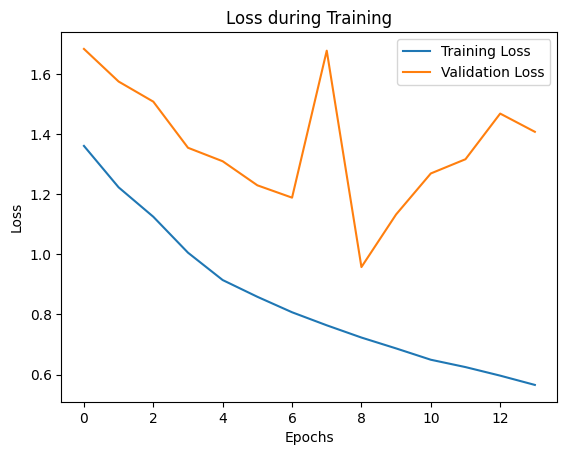

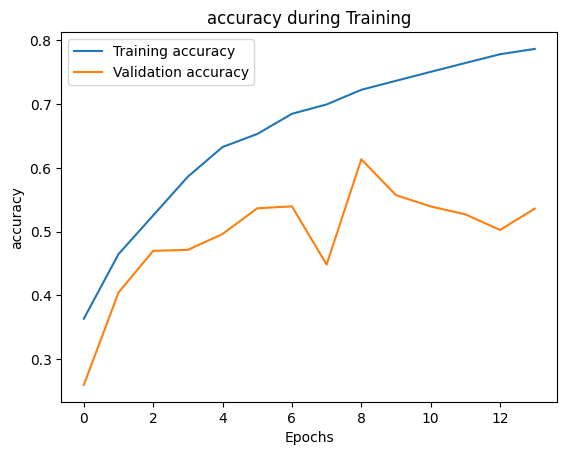

In [16]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    plt.figure(figsize=(12, 12))
    
    # Pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('accuracy during Training')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


# Llamar a la función para graficar el progreso del entrenamiento
plot_training_history(history)


1/1 [==============================] - 1s 735ms/step


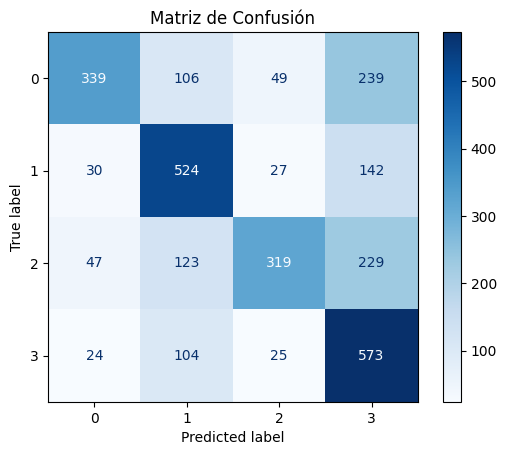

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in val:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(4))  # Ajusta el rango según tus clases
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

In [60]:
import pickle

history_path = "E:/TFM/history3.pkl"
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

print(f"💾 Historial guardado en: {history_path}")


💾 Historial guardado en: E:/TFM/history3.pkl


In [17]:
import tensorflow as tf

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/train',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(224, 224),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)


test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/test',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(224, 224),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/val',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(224, 224),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)

Found 20300 files belonging to 29 classes.
Found 5800 files belonging to 29 classes.
Found 2900 files belonging to 29 classes.


In [62]:



# Aplicamos la función


In [19]:
model = tf.keras.models.load_model("E:/TFM/rotnet_model3.keras")

rotnet_model= model
encoder = Model(
    inputs=rotnet_model.input,
    outputs=rotnet_model.layers[-2].output  # penúltima capa (antes de Dense(4))
)
for layer in encoder.layers:
    layer.trainable = True  # o True si vas a hacer fine-tuning
plant_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(29, activation='softmax')
])
plant_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                      

In [64]:
# # encoder=rotnet_model=model = base_model = tf.keras.applications.MobileNetV2(weights="imagenet",include_top=True, input_shape=(224, 224, 3))
# # encoder.trainable = False  # Congelar el modelo base
# rotnet_model= model
# encoder = Model(
#     inputs=rotnet_model.input,
#     outputs=rotnet_model.layers[-2].output  # penúltima capa (antes de Dense(4))
# )
# for layer in encoder.layers:
#     layer.trainable = False  # o True si vas a hacer fine-tuning
# plant_model = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Flatten(),  # or GlobalAveragePooling2D() if Flatten hasn't been applied earlier
#     tf.keras.layers.Dense(512, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(256, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(64, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(30, activation="softmax")
# ])
# plant_model.summary()

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='best_modelV5.h5', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.2, min_lr=1e-6),
]

history = model.fit(
    train,
    validation_data=test,
    epochs=50,
    callbacks=callbacks,
    verbose=1

)
save_path = "E:/TFM/plant_model_full3.keras"
plant_model.save(save_path)
print(f"💾 Modelo guardado en: {save_path}")


Epoch 1/50
635/635 [==============================] - 193s 277ms/step - loss: 5.5925 - accuracy: 0.3014 - val_loss: 5.3735 - val_accuracy: 0.2209 - lr: 1.0000e-04
Epoch 2/50
635/635 [==============================] - 175s 274ms/step - loss: 4.0956 - accuracy: 0.4490 - val_loss: 3.5117 - val_accuracy: 0.4800 - lr: 1.0000e-04
Epoch 3/50
635/635 [==============================] - 175s 274ms/step - loss: 3.2657 - accuracy: 0.4690 - val_loss: 2.8906 - val_accuracy: 0.5305 - lr: 1.0000e-04
Epoch 4/50
635/635 [==============================] - 175s 274ms/step - loss: 2.6581 - accuracy: 0.4860 - val_loss: 2.4437 - val_accuracy: 0.4347 - lr: 1.0000e-04
Epoch 5/50
635/635 [==============================] - 176s 275ms/step - loss: 2.2679 - accuracy: 0.5060 - val_loss: 2.0635 - val_accuracy: 0.4993 - lr: 1.0000e-04
Epoch 6/50
635/635 [==============================] - 175s 274ms/step - loss: 1.9385 - accuracy: 0.5536 - val_loss: 1.9603 - val_accuracy: 0.4634 - lr: 1.0000e-04
Epoch 7/50
635/635 [==

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential/dense/MatMul/MatMul_1' defined at (most recent call last):
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_9376\3834665058.py", line 13, in <module>
      history = model.fit(
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential/dense/MatMul/MatMul_1'
OOM when allocating tensor with shape[100352,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential/dense/MatMul/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_15425]

In [9]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    plt.figure(figsize=(12, 12))
    
    # Pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('accuracy during Training')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


# Llamar a la función para graficar el progreso del entrenamiento
plot_training_history(history)

NameError: name 'history' is not defined

c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1/1 [==============================] - 1s 834ms/step
Accuracy de validación: 0.67


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (29).

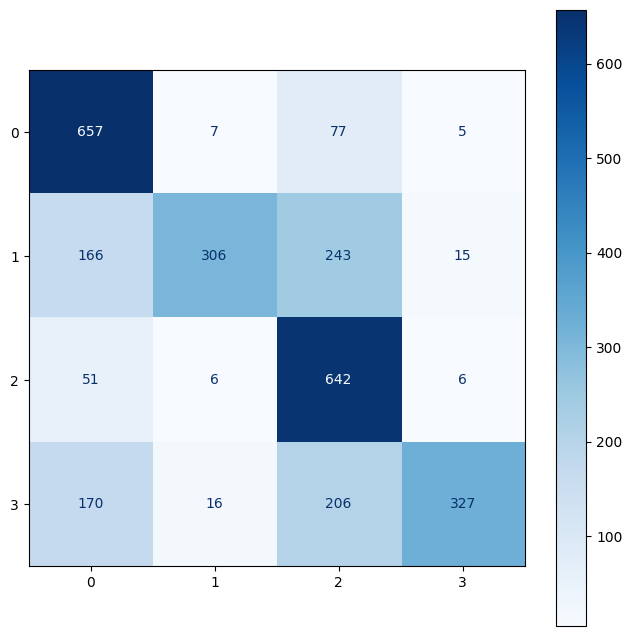

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
#load the best model
from transformers.models.vit_mae.modeling_tf_vit_mae import TFViTMAEMainLayer

# Load the best model with custom objects
# model_ = keras.models.load_model("best_modelV5.h5", custom_objects={"TFViTMAEMainLayer": TFViTMAEMainLayer})
# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in val:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
# elmina la etiqueta 3
# y_true = [label for label in y_true if label != 3]
# y_pred = [pred for pred, label in zip(y_pred, y_true) if label != 3]
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy de validación: {accuracy:.2f}")
# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(29))  # Ajusta el rango según tus clases
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title("Matriz de Confusión")
plt.show()